In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd

import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

from itertools import product
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Archimedes procedure for porous material density determination

Experimental procedure is as follow, for further detail refer to standard ISO 5017. 

1. Measure temperature of liquid to determine its ($\rho_{\text{liq}}$) and find object theoretical full density ( $\rho_{\text{solid}}$ ) from datasheet
2. Measure mass of sample(s) in air ($m_1$)
3. Impregnate sample(s) in fluid (Isopropanol) 
4. Measure mass of wet sample(s) suspended in fluid ($m_2$)
5. Remove sample from balance and measure mass of soaked piece ($m_3$)

\begin{equation}
    \text{bulk density}, \rho_b = \frac{m_1}{m_3-m_2}*\rho_{\text{liq}}
\end{equation}

\begin{equation}
    \text{true density}, \pi_d = \frac{ \rho_b}{\rho_{\text{solid}}} * 100
\end{equation}

Parts using two powder type are made. Parts labeled bimodal should have a higher density then parts labelled unimodal.

## Load Data from excel sheet

In [2]:
data = pd.read_excel('./data/green_sample_benchmark.xlsx', sheet_name = 'archimedes', index_col= [0,1])
iso_density = pd.read_excel('./data/green_sample_benchmark.xlsx', sheet_name = 'arch_param', index_col= 0)

## Display first few row of excel sheet

In [3]:
data.head()

powder type  dry weight  wet coated  coated weight  exp  operator
batch ID                                                                    
4     3.0     Unimodal     14.8038     13.2572        15.9512    1         1
      3.0     Unimodal     14.7935     13.2525        15.9485    1         1
      8.0     Unimodal     15.2090     13.6240        16.3252    1         1
      8.0     Unimodal     15.2038     13.6184        16.3211    1         1
      14.0    Unimodal     15.3370     13.7548        16.4814    1         1

## Carrier fluid density

Density of the carrier fluid ($\rho_{\text{liq}}$) is necessary for density calculation. Since the density of the fluid fluctuate depending on temperature and temperature varies from experiment to experiment, it is recorded for each experiment. For experiment 2 it was recorded at the beginning and at the end.

In [21]:
iso_density

,density isopropanol
exp,
1,0.7842
2,0.7842
2,0.7838


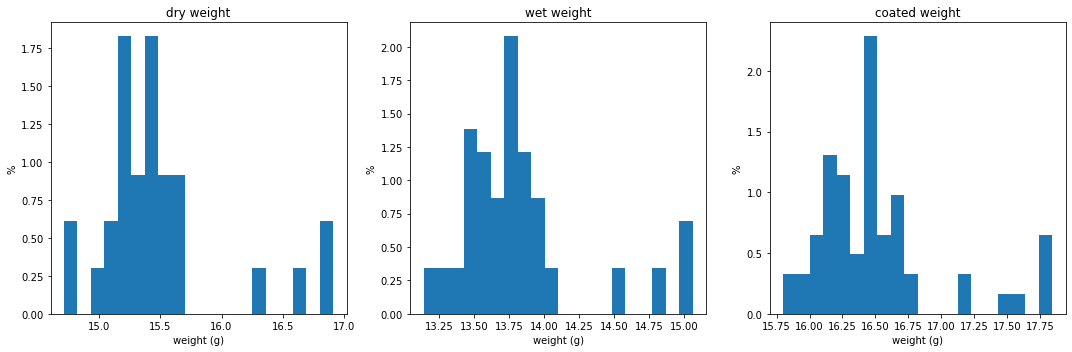

In [28]:
def plot_hist(data, b):
    fig, axes = plt.subplots(1,3, figsize = (15,5))
    axes[0].hist(data['dry weight'], bins = b, density = True)
    axes[0].set_title('dry weight')
    axes[0].set_xlabel('weight (g)')
    axes[0].set_ylabel('%')

    axes[1].hist(data['wet coated'], bins = b, density = True)
    axes[1].set_title('wet weight')
    axes[1].set_xlabel('weight (g)')
    axes[1].set_ylabel('%')

    axes[2].hist(data['coated weight'], bins = b, density = True)
    axes[2].set_title('coated weight')
    axes[2].set_xlabel('weight (g)')
    axes[2].set_ylabel('%')
    
    plt.tight_layout()
    plt.show()

plot_hist(data, 20)

## Compute density
Each sample was measured 3 times at each stage. Since we are only interested in the uncertainty in the true density ($\pi_t$), a cartesian product of each measured weights (dry, wet and coated) and liquid density is done for each sample in order to compute true density.

In [6]:
density_df = pd.DataFrame(columns = ['batch', 'id', 'density', 'operator', 'powder'])

# density of stainless steel 316L (g/cc) taken from data sheet
den_ss316 = 8.0

unique_id = 0

# iterate over each sample to do cartesian product
for idx in data.index.unique():
    sample = data.loc[idx]

    op = int(np.unique(sample['operator']).squeeze())
    powder = str(np.unique(sample['powder type']).squeeze())
    batch = idx[0]

    d_weight = sample['dry weight'].to_numpy()
    wc_weight = sample['wet coated'].to_numpy()
    c_weight = sample['coated weight'].to_numpy()

    exp_num = sample['exp']
    # density of liquid taken from datasheet
    iso_den = iso_density.loc[exp_num].to_numpy()
    
    # cartesian product
    prod = product(d_weight, wc_weight, c_weight, iso_den)

    for d_w, wc_w, c_w, iso_d in prod:
        #compute true density refer to equation on top
        den = (d_w/(c_w - wc_w)*iso_d)/den_ss316*100
        new_entry = {
            'batch' : batch,
            'id' : unique_id,
            'density' : float(den.squeeze()),
            'operator' : op,
            'powder' : powder
        }

        density_df = density_df.append(new_entry, ignore_index = True)
    
    unique_id += 1

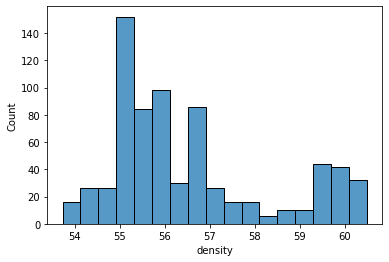

In [7]:
ax = sns.histplot(density_df['density'])

In [8]:
density_df.to_csv('./data/density_archimedes.csv', index=False)

In [9]:
density_df.head()

,batch,id,density,operator,powder
0,4,0,53.865720,1,Unimodal
1,4,0,53.865720,1,Unimodal
2,4,0,53.919760,1,Unimodal
3,4,0,53.919760,1,Unimodal
4,4,0,53.771909,1,Unimodal


## Setup Model

Fitted a nested model, since samples are not reused across experiment. 

\begin{equation}
    y_{ijk}  = \mu_{i} + Part_{j(i)} + \epsilon_{k(ij)}
    \label{eq:Model}
\end{equation}

Each powder type follows a global mean density $\mu_{i}$. Since the measurement is destructive, therefore the same parts cannot be measured using different methods. Consequently, $Part_{j(i)}$ represent the nesting relationship between the Fixed effect of the powder and the measurement of each part. Finally, $\epsilon_{k(ij)}$ represents the measurement error ($\sigma_{gage}$). An operator and a batch random effect were previously included in the model. Including the two effects caused the sampler to diverge. The cause of the divergence was likely due to the low number of replicates for the operator(2). As for the batch effect, the removal did not change the estimated value for $\sigma_{gage}$. Therefore, it is likely that the variance due to the batch is very low. The model is set up as follows:

\begin{align*}
    \{\mu_{i} \sim Uniform(20.0, 60.0)&: i = \{\text{Unimodal},\text{Bimodal}\}\} \\
    \text{Part}_{j(i)} &\sim N(0, \sigma_{\text{part}}) \\
    \mu &= \mu_{i} + \text{Part}_{j(i)} \\
    y_{ijk} &\sim  N(\mu, \sigma_{\text{gage}}) 
\end{align*}
\begin{equation}
    \sigma_{\text{part}} \sim \text{HalfCauchy}(25)
    \label{eq:model_priors_p}
\end{equation}
\begin{equation}
    \sigma_{\text{gage}} \sim \text{HalfCauchy}(25) 
    \label{eq:model_priors_g}
\end{equation}

In [10]:
basic_model = pm.Model()

n_part = unique_id

powder_mean = density_df.groupby('powder').mean()['density']

part_id = density_df['id'].to_numpy().astype(np.int32)
obs_den = density_df['density'].to_numpy().astype(np.int32)

# Relabel data to integers
powder_enc = preprocessing.LabelEncoder()
powder_enc.fit(['Unimodal','Bimodal'])
powder_data = powder_enc.transform(density_df['powder'])

#compute starting point for mean inference
test_val_mu = [powder_mean[c] for c in powder_enc.classes_]

A = 10000
with basic_model:
    
    # setup independent mu_i
    mu_p = pm.Uniform('muP', 20.0, 60.0, shape = 2, testval = test_val_mu)
    mu_real = pm.math.switch(powder_data, mu_p[1], mu_p[0])
    
    # setup prior for part variance and error variance
    sig_repeat = pm.HalfCauchy('sig_repeat', 25)
    sig_part = pm.HalfCauchy('sig_part', 25)
    
    # each part will vary independently (nesting relationship)
    P_t = pm.Normal('P_t', mu = 0, sigma = 1, shape = n_part)
    
    # setup mu
    mu = pm.Deterministic('mu', mu_real + P_t[part_id]*sig_part)
    
    # add error and data to model
    porosity = pm.Normal('density', mu = mu, sigma = sig_repeat, observed = obs_den)


## Run Inference

In [11]:
with basic_model:
    trace = pm.sample(A, chains = 4, tune = 2000, target_accept=0.9)
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [P_t, sig_part, sig_repeat, muP]
Sampling 4 chains, 0 divergences: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48000/48000 [02:21<00:00, 340.06draws/s]
The number of effective samples is smaller than 10% for some parameters.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [00:34<00:00, 1167.65it/s]


Convert trace to arviz data format for diagnostic

In [12]:
trace_data_az = az.from_pymc3(
    trace=trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    model=basic_model
)

In [13]:
# save trace for future use
trace_data_az.to_netcdf('./data/arch_trace.nc')

'./data/arch_trace.nc'

## Trace plot
The sampler is exploring the probability space by sampling different values of the model input parameters ($\mu_i, \sigma_{\text{part}}, \sigma_{\text{gage}}$). The left graph shows the probability density of the sampled values. The right graph shows the sampled with respect to sample number. The left graph is computed by summing up the right graph. When the left graph looks skewed towards zero or the right graph does not resemble a thick caterpillar, this indicates a biased sampling and a lack of convergence. 

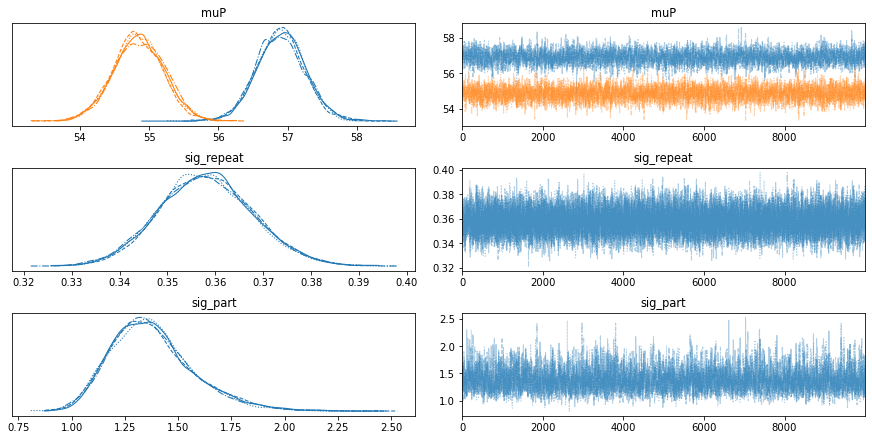

In [14]:
pm.traceplot(trace, var_names=['muP','sig_repeat','sig_part'])
plt.show()

## Predictive check plot

Predictive posterior plot overlays data generated by the model's posterior over the real data. This is useful to check the fitness of the model. 

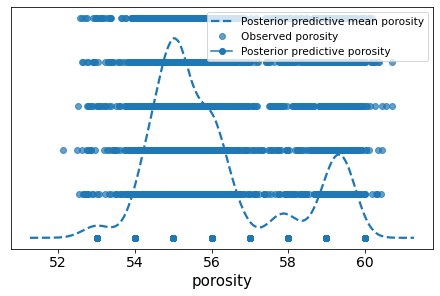

In [15]:
az.plot_ppc(trace_data_az, data_pairs={"density":"density"}, kind = 'scatter')
plt.show()

## Forest plot

Forest plot on estimated real mean $\mu_{i}$ to check if the values make sense

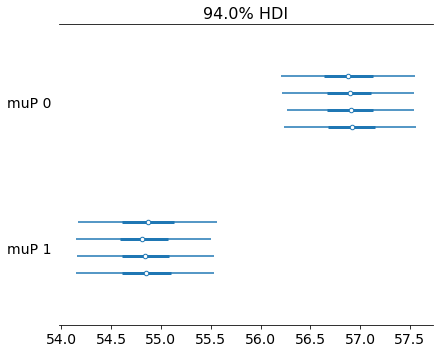

In [16]:
pm.plots.forestplot(trace, var_names=['muP'])
plt.show()

## Compute split $\hat{R}$ 

In the Markov-Chain Monte Carlo (MCMC) sampler, the sampling is done simultaneously in multiple processes (chain). The rank normalized $\hat{R}$ checks for convergence by comparing the variance between chain with the variance within chain. If convergence has been achieved then the variance should be the same ($\hat{R}=1$) (Vehtari et al). [Vehtari et al.](https://arxiv.org/pdf/1903.08008v1.pdf "vehtari") recommends a $\hat{R} < 1.01$.


In [17]:
az.rhat(trace_data_az)

<xarray.Dataset>
Dimensions:     (P_t_dim_0: 30, muP_dim_0: 2, mu_dim_0: 720)
Coordinates:
  * P_t_dim_0   (P_t_dim_0) int32 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29
  * muP_dim_0   (muP_dim_0) int32 0 1
  * mu_dim_0    (mu_dim_0) int32 0 1 2 3 4 5 6 7 ... 713 714 715 716 717 718 719
Data variables:
    P_t         (P_t_dim_0) float64 1.001 1.002 1.002 ... 1.002 1.002 1.002
    muP         (muP_dim_0) float64 1.002 1.002
    sig_repeat  float64 1.001
    sig_part    float64 1.001
    mu          (mu_dim_0) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0

## Calculate highest density interval (HDI)

Taken from [arviz doc](https://arviz-devs.github.io/arviz/api/generated/arviz.hdi.html#arviz.hdi "arviz") : The HDI is the minimum width Bayesian credible interval (BCI).

In [20]:
hdi_data = az.hdi(trace_data_az)
hdi_data.to_netcdf('./data/arch_inference.nc')
hdi_data

<xarray.Dataset>
Dimensions:     (P_t_dim_0: 30, hdi: 2, muP_dim_0: 2, mu_dim_0: 720)
Coordinates:
  * P_t_dim_0   (P_t_dim_0) int32 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29
  * muP_dim_0   (muP_dim_0) int32 0 1
  * mu_dim_0    (mu_dim_0) int32 0 1 2 3 4 5 6 7 ... 713 714 715 716 717 718 719
  * hdi         (hdi) <U6 'lower' 'higher'
Data variables:
    P_t         (P_t_dim_0, hdi) float64 -2.005 -0.7537 ... -0.9807 0.06227
    muP         (muP_dim_0, hdi) float64 56.23 57.55 54.15 55.54
    sig_repeat  (hdi) float64 0.3397 0.3766
    sig_part    (hdi) float64 1.036 1.753
    mu          (mu_dim_0, hdi) float64 52.84 53.18 52.84 ... 54.37 54.13 54.37